# 04 – 1‑Layer Neural Network on TF–IDF Features

In this notebook we will:
1. Load the train/val/test splits for our chosen task (e.g. SP).  
2. Apply the same `clean_text()` as before.  
3. Fit a TF–IDF vectorizer to the train set and transform all splits.  
4. Convert TF–IDF matrices to PyTorch `Dataset`/`DataLoader`.  
5. Define a one‑layer MLP: 20 000 → 512 → 2 (softmax) with dropout.  
6. Train with Adam optimizer, monitoring train/val loss and F1.  
7. Plot training curves and evaluate on test set.  
8. Save the trained model.  

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import joblib

%matplotlib inline
plt.style.use('ggplot')


In [2]:
# Notebook parameters
TASK = "sp"                 # or "hh" / "bd"
MAX_FEATURES = 20000
HIDDEN_DIM = 512
DROPOUT = 0.5
LR = 1e-3
BATCH_SIZE = 256
EPOCHS = 10
PATIENCE = 2               # early stopping patience on val F1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# Load splits
train_df = pd.read_csv(f"project_splits/{TASK}_train.csv")
val_df   = pd.read_csv(f"project_splits/{TASK}_val.csv")
test_df  = pd.read_csv(f"project_splits/{TASK}_test.csv")

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 368069, Val: 52581, Test: 105164


In [5]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\quant\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\quant\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\quant\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load stopwords and lemmatizer
STOP = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    txt = text.lower()
    txt = re.sub(r'<[^>]+>', ' ', txt)
    txt = re.sub(r'http\S+|www\.\S+', ' ', txt)
    txt = re.sub(r'[^a-z\s]', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    tokens = [w for w in txt.split() if w not in STOP]
    return ' '.join(lemmatizer.lemmatize(w) for w in tokens)

# Apply cleaning to each DataFrame
for df in (train_df, val_df, test_df):
    df["Text"] = df["Text"].fillna("")           # Fill missing values with empty string
    df["cleaned"] = df["Text"].apply(clean_text) # Apply cleaning


In [8]:
# TF–IDF vectorization
tfidf = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1,2))
X_train = tfidf.fit_transform(train_df["cleaned"])
X_val   = tfidf.transform(val_df["cleaned"])
X_test  = tfidf.transform(test_df["cleaned"])

y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = test_df["label"].values

# Save TF–IDF for reuse
joblib.dump(tfidf, f"models/{TASK}_tfidf_vectorizer.joblib")


['../models/sp_tfidf_vectorizer.joblib']

In [9]:
# Convert to PyTorch datasets
def make_loader(X, y, batch_size, shuffle=False):
    X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    ds = TensorDataset(X_tensor, y_tensor)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, BATCH_SIZE, shuffle=True)
val_loader   = make_loader(X_val,   y_val,   BATCH_SIZE)
test_loader  = make_loader(X_test,  y_test,  BATCH_SIZE)


In [17]:
# Define the one-layer MLP
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(MAX_FEATURES, HIDDEN_DIM, DROPOUT).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


In [18]:
import time
# Training loop with early stopping on val F1
best_val_f1 = 0.0
patience_counter = 0
history = {"train_loss": [], "val_loss": [], "val_f1": [], 'epoch_time': []}

for epoch in range(1, EPOCHS+1):

    epoch_start = time.time()
    # Train
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    train_loss = total_loss / len(train_loader.dataset)

    # Validate
    model.eval()
    val_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            logits = model(Xb)
            val_loss += criterion(logits, yb).item() * Xb.size(0)
            preds.extend(logits.argmax(dim=1).cpu().tolist())
            targets.extend(yb.cpu().tolist())
    val_loss /= len(val_loader.dataset)
    val_f1 = f1_score(targets, preds, average="binary")

    # Find total Epoch time
    epoch_time = time.time() - epoch_start

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_f1"].append(val_f1)
    history['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_f1={val_f1:.4f} epoch_time={epoch_time:.4f}")

    #Save models for demo
    torch.save(model.state_dict(), f'models/{TASK}_nn_{EPOCHS}.pth')

    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), f"models/{TASK}_nn_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 1 | train_loss=0.1758 val_loss=0.1379 val_f1=0.9689 epoch_time=111.0168
Epoch 2 | train_loss=0.1123 val_loss=0.1274 val_f1=0.9721 epoch_time=107.6935
Epoch 3 | train_loss=0.0802 val_loss=0.1244 val_f1=0.9738 epoch_time=113.9458
Epoch 4 | train_loss=0.0522 val_loss=0.1304 val_f1=0.9740 epoch_time=113.1080
Epoch 5 | train_loss=0.0315 val_loss=0.1413 val_f1=0.9745 epoch_time=126.7026
Epoch 6 | train_loss=0.0183 val_loss=0.1527 val_f1=0.9744 epoch_time=116.8166
Epoch 7 | train_loss=0.0112 val_loss=0.1712 val_f1=0.9739 epoch_time=114.3668
Early stopping triggered.


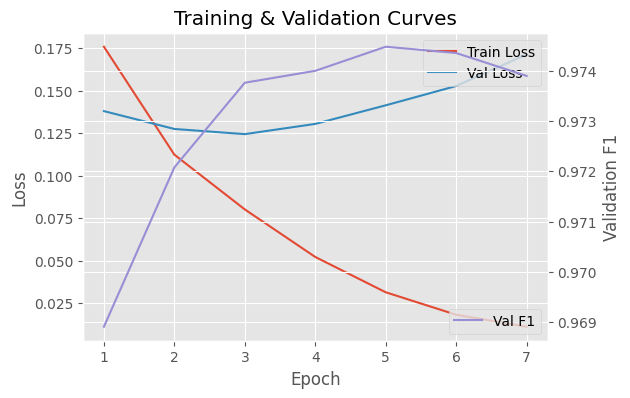

In [19]:
# Plot training curves
epochs = range(1, len(history["train_loss"]) + 1)
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(epochs, history["train_loss"], label="Train Loss")
ax1.plot(epochs, history["val_loss"],   label="Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")

ax2 = ax1.twinx()
ax2.plot(epochs, history["val_f1"], color="C2", label="Val F1")
ax2.set_ylabel("Validation F1")
ax2.legend(loc="lower right")
plt.title("Training & Validation Curves")
plt.show()


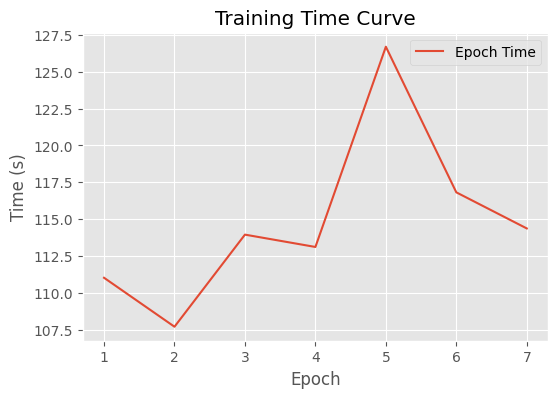

In [22]:
fig, ax3 = plt.subplots(figsize=(6,4))
ax3.plot(epochs, history["epoch_time"], label="Epoch Time")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Time (s)")
ax3.legend(loc="upper right")
plt.title("Training Time Curve")
plt.show()

              precision    recall  f1-score   support

           0      0.889     0.827     0.857     16407
           1      0.968     0.981     0.975     88757

    accuracy                          0.957    105164
   macro avg      0.929     0.904     0.916    105164
weighted avg      0.956     0.957     0.956    105164



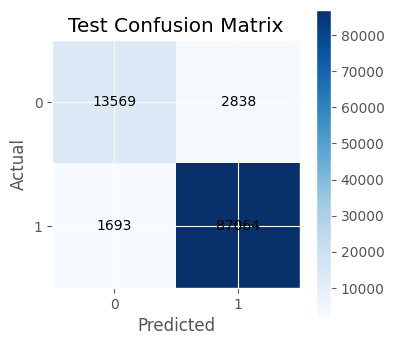

In [23]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load(f"models/{TASK}_nn_best.pth"))
model.eval()
preds, targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(DEVICE)
        logits = model(Xb)
        preds.extend(logits.argmax(dim=1).cpu().tolist())
        targets.extend(yb.tolist())

print(classification_report(targets, preds, digits=3))
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks([0,1], ["0","1"])
plt.yticks([0,1], ["0","1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in (0,1):
    for j in (0,1):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.title("Test Confusion Matrix")
plt.show()


In [25]:
# Save the final model (optionally together with tfidf)
torch.save(model.state_dict(), f"models/{TASK}_nn_final.pth")
print(f"Model saved to models/{TASK}_nn_final.pth")


Model saved to models/sp_nn_final.pth
